# 分割segment类型的原始数据为 --> train-val-test

## 需要先将所有数据放在一个文件夹下
```
raw
|——images
|  |——xxx.png
|——labels
   |——xxx.txt
```

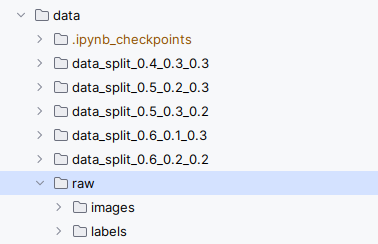

In [5]:
import os
import shutil
import random
from pathlib import Path
from typing import Optional

# ========= 用户配置 =========
DATA_ROOT = Path("/workspace/_ty/models/runs_yolov11/raw_data")  # 里面应有 images/ 与 labels/
SPLITS = {"train": 0.8, "val": 0.2, "test": 0.0}
OUT_ROOT  = Path(f"data/data_split_{SPLITS['train']}_{SPLITS['val']}_{SPLITS['test']}")  # 输出目录
IMG_EXTS   = {".jpg", ".jpeg", ".png"}
LABEL_EXTS = {".txt", ".json", ".png", ".bmp"}  # 文本标注或掩膜标注
SEED = 42

# 处理策略
KEEP_UNLABELED = False              # 是否保留无标注（或空标注）样本为负样本
CHECK_MASK_PIXELS = True            # 掩膜是否检查像素值（全 0 视为空）
CREATE_EMPTY_MASK_FOR_NEG = False   # 为负样本生成空掩膜文件
EMPTY_TXT_CONTENT = ""              # YOLO 分割任务，空 txt 内容
# ========= 顺序切分配置 =========
SEQUENTIAL_SPLIT = True             # True=按顺序切分，False=随机切分
SEQUENTIAL_KEY = "name"             # "name"=按文件名，"mtime"=按修改时间
# ===============================

def is_image_file(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def find_label_for(stem: str, labels_dir: Path) -> Optional[Path]:
    for ext in LABEL_EXTS:
        cand = labels_dir / f"{stem}{ext}"
        if cand.exists():
            return cand
    return None

def label_is_empty(label_path: Path) -> bool:
    ext = label_path.suffix.lower()
    if ext in {".txt", ".json"}:
        try:
            if label_path.stat().st_size == 0:
                return True
            txt = label_path.read_text(encoding="utf-8", errors="ignore").strip()
            return len(txt) == 0
        except Exception:
            return True
    if ext in {".png", ".bmp"}:
        if not CHECK_MASK_PIXELS:
            return False
        try:
            from PIL import Image
            import numpy as np
            with Image.open(label_path) as im:
                arr = np.array(im)
                return arr.max() == 0
        except Exception:
            return True
    return False

def ensure_dirs():
    for split in SPLITS:
        (OUT_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
        (OUT_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

def copy_pair(img: Path, lbl: Optional[Path], split: str):
    dst_img = OUT_ROOT / split / "images" / img.name
    shutil.copy2(img, dst_img)

    if lbl is not None:
        dst_lbl = OUT_ROOT / split / "labels" / lbl.name
        shutil.copy2(lbl, dst_lbl)
    else:
        if CREATE_EMPTY_MASK_FOR_NEG:
            from PIL import Image
            import numpy as np
            with Image.open(img) as im:
                w, h = im.size
            empty = Image.fromarray(np.zeros((h, w), dtype='uint8'))
            dst_lbl = OUT_ROOT / split / "labels" / (img.stem + ".png")
            empty.save(dst_lbl)
        else:
            dst_lbl = OUT_ROOT / split / "labels" / (img.stem + ".txt")
            dst_lbl.write_text(EMPTY_TXT_CONTENT, encoding="utf-8")

def main():
    images_dir = DATA_ROOT / "images"
    labels_dir = DATA_ROOT / "labels"

    imgs = [p for p in images_dir.rglob("*")
            if p.is_file() and is_image_file(p) and ".ipynb_checkpoints" not in p.parts]

    pairs_keep = []
    skipped = []

    for img in imgs:
        stem = img.stem
        lbl = find_label_for(stem, labels_dir)

        if lbl is None:
            if KEEP_UNLABELED:
                pairs_keep.append((img, None))
            else:
                skipped.append((img, "no_label_file"))
            continue

        if label_is_empty(lbl):
            if KEEP_UNLABELED:
                pairs_keep.append((img, None))
            else:
                skipped.append((img, f"empty_label:{lbl.suffix.lower()}"))
        else:
            pairs_keep.append((img, lbl))

    # === 顺序 / 随机切分 ===
    if SEQUENTIAL_SPLIT:
        if SEQUENTIAL_KEY == "name":
            pairs_keep.sort(key=lambda x: x[0].name.lower())
        elif SEQUENTIAL_KEY == "mtime":
            pairs_keep.sort(key=lambda x: x[0].stat().st_mtime)
        else:
            raise ValueError(f"Unknown SEQUENTIAL_KEY: {SEQUENTIAL_KEY}")
    else:
        random.seed(SEED)
        random.shuffle(pairs_keep)

    n = len(pairs_keep)
    n_train = int(SPLITS["train"] * n)
    n_val   = int(SPLITS["val"] * n)

    splits = {
        "train": pairs_keep[:n_train],
        "val":   pairs_keep[n_train:n_train+n_val],
        "test":  pairs_keep[n_train+n_val:]
    }

    ensure_dirs()
    for split, items in splits.items():
        for img, lbl in items:
            copy_pair(img, lbl, split)

    print("✅ Done.")
    print(f"Kept total: {n} | train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")
    if skipped:
        from collections import Counter
        reasons = Counter([r for _, r in skipped])
        print(f"Skipped: {len(skipped)} | reasons={dict(reasons)}")

if __name__ == "__main__":
    main()


✅ Done.
Kept total: 759 | train=607, val=151, test=1
